In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# pointofview library is needed to determine if a sentence is in first/second/third person
!pip install pointofview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pointofview

In [4]:
# We need a custom function to get the POV in order to remove NoneType, because that would give an error later on
def custom_pov(sentence):
  if pointofview.get_text_pov(sentence) == None:
    return 'none'
  else:
    return pointofview.get_text_pov(sentence)

In [5]:
# Connect to google drive to get the csv files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the data and check the first few entries
%cd /content/drive/MyDrive/
train_df = pd.read_csv('train_set.csv')

test_df = pd.read_csv('test_set.csv')
test_df.head()

/content/drive/MyDrive


,thread_id,comment_id,sentence,comment,id,verif,personal,difficulty,annotator,annotation_id,created_at,updated_at,lead_time
0,t3_4xsg8k,d6iux4x,I have spent 6 years at 2 different universiti...,I have spent 6 years at 2 different universiti...,4653,UnVerif,NaN,NaN,1,4653,2022-05-02T15:37:41.172039Z,2022-05-02T15:37:41.172075Z,10.614
1,t3_4xsg8k,d6iux4x,They seem like small private groups that peopl...,I have spent 6 years at 2 different universiti...,4654,UnVerif,NaN,NaN,1,4654,2022-05-02T15:45:49.059809Z,2022-05-02T15:45:49.059873Z,487.322
2,t3_4xsg8k,d6iux4x,Do you have evidence of safe spaces growing an...,I have spent 6 years at 2 different universiti...,4655,NonArg,NaN,NaN,1,4655,2022-05-02T15:45:50.909690Z,2022-05-02T15:45:50.909729Z,1.598
3,t3_4xsg8k,d6ishdg,A safe space isn't inherently a bad thing.,A safe space isn't inherently a bad thing. Thi...,4656,UnVerif,NaN,NaN,1,4656,2022-05-02T15:45:55.792114Z,2022-05-02T15:45:55.792152Z,4.646
4,t3_4xsg8k,d6ishdg,Think of it like a club.,A safe space isn't inherently a bad thing. Thi...,4657,UnVerif,NaN,NaN,1,4657,2022-05-02T15:45:58.288064Z,2022-05-02T15:45:58.288102Z,2.160


In [7]:
# REFINE THE TRAIN DATAFRAME
# Drop the columns not needed (for now)
train_df_refined = train_df.drop(['thread_id', 'comment_id', 'comment', 'id', 'annotator', 'annotation_id', 'created_at', 'updated_at', 'lead_time'], axis = 1)

# Add word count
train_df_refined['word_count'] = train_df_refined['sentence'].apply(lambda x: len(x.split()))

# Add point of view
train_df_refined['pov'] = train_df_refined['sentence'].apply(lambda x: custom_pov(x))

# Show first 5 entries
train_df_refined.head()

,sentence,verif,personal,difficulty,word_count,pov
0,"I have so many responses to this, but most of ...",UnVerif,NaN,NaN,26,first
1,1,NonArg,NaN,NaN,1,none
2,"When you say things like ""drain on society"" or...",UnVerif,NaN,NaN,26,second
3,For every person who takes more than they give...,UnVerif,NaN,NaN,19,third
4,Most of the people in America don't see a dime...,Verif,NonPers,Difficult,33,third


In [8]:
# REFINE THE TEST DATAFRAME
# Drop the columns not needed (for now)
test_df_refined = test_df.drop(['thread_id', 'comment_id', 'comment', 'id', 'annotator', 'annotation_id', 'created_at', 'updated_at', 'lead_time'], axis = 1)

# Add word count
test_df_refined['word_count'] = test_df_refined['sentence'].apply(lambda x: len(x.split()))

# Add point of view
test_df_refined['pov'] = test_df_refined['sentence'].apply(lambda x: custom_pov(x))

# Show first 5 entries
test_df_refined.head()

,sentence,verif,personal,difficulty,word_count,pov
0,I have spent 6 years at 2 different universiti...,UnVerif,NaN,NaN,44,first
1,They seem like small private groups that peopl...,UnVerif,NaN,NaN,30,third
2,Do you have evidence of safe spaces growing an...,NonArg,NaN,NaN,13,second
3,A safe space isn't inherently a bad thing.,UnVerif,NaN,NaN,8,none
4,Think of it like a club.,UnVerif,NaN,NaN,6,third


In [9]:
# To get the POS Count feature, we need to add the POS tags to each word
nlp = spacy.load("en_core_web_sm")

def get_POS_tags(sentence):
  doc = nlp(sentence)
  POS_tag_list = []
  for token in doc:
    POS_tag = token.pos_
    POS_tag_list.append(POS_tag) 
  return " ".join(POS_tag_list)


    
train_df_refined['POS_tags'] = train_df_refined['sentence'].apply(lambda x: get_POS_tags(x)) 
test_df_refined['POS_tags'] = test_df_refined['sentence'].apply(lambda x: get_POS_tags(x)) 
  

In [10]:
# Function for determining the tense of a sentence
def determine_tense(sentence):
  doc = nlp(sentence)
  for token in doc:
    future_tense = False
    if 'Tense_pres' in nlp.vocab.morphology.tag_map[token.tag_].keys():
      return 'present'
      break
    elif 'Tense_past' in nlp.vocab.morphology.tag_map[token.tag_].keys():
      return 'past'
      break
    elif 'VerbType_mod' in nlp.vocab.morphology.tag_map[token.tag_].keys():
      future_tense = True
    elif 'VerbForm_inf' in nlp.vocab.morphology.tag_map[token.tag_].keys():
      return 'future'
      future_tense = False
      break

def remove_none_from_tense(sentence):
  if determine_tense(sentence) == None:
    return 'none'
  else:
    return determine_tense(sentence)

train_df_refined['tense'] = train_df_refined['sentence'].apply(lambda x: remove_none_from_tense(x)) 
test_df_refined['tense'] = test_df_refined['sentence'].apply(lambda x: remove_none_from_tense(x)) 

In [ ]:
train_df_refined.head()

,sentence,verif,personal,difficulty,word_count,pov,POS_tags,tense
0,"I have so many responses to this, but most of ...",UnVerif,NaN,NaN,26,first,PRON AUX ADV ADJ NOUN ADP DET PUNCT CCONJ ADJ ...,present
1,1,NonArg,NaN,NaN,1,none,X,none
2,"When you say things like ""drain on society"" or...",UnVerif,NaN,NaN,26,second,ADV PRON VERB NOUN SCONJ PUNCT VERB ADP NOUN P...,present
3,For every person who takes more than they give...,UnVerif,NaN,NaN,19,third,ADP DET NOUN PRON VERB ADJ SCONJ PRON VERB PUN...,present
4,Most of the people in America don't see a dime...,Verif,NonPers,Difficult,33,third,ADJ ADP DET NOUN ADP PROPN AUX PART VERB DET N...,present


In [ ]:
test_df_refined.head()

,sentence,verif,personal,difficulty,word_count,pov,POS_tags,tense
0,I have spent 6 years at 2 different universiti...,UnVerif,NaN,NaN,44,first,PRON AUX VERB NUM NOUN ADP NUM ADJ NOUN CCONJ ...,present
1,They seem like small private groups that peopl...,UnVerif,NaN,NaN,30,third,PRON VERB SCONJ ADJ ADJ NOUN DET NOUN VERB DET...,present
2,Do you have evidence of safe spaces growing an...,NonArg,NaN,NaN,13,second,AUX PRON AUX NOUN ADP ADJ NOUN VERB CCONJ VERB...,present
3,A safe space isn't inherently a bad thing.,UnVerif,NaN,NaN,8,none,DET ADJ NOUN AUX PART ADV DET ADJ NOUN PUNCT,present
4,Think of it like a club.,UnVerif,NaN,NaN,6,third,VERB ADP PRON SCONJ DET NOUN PUNCT,future


In [11]:
# Train test split for main classes
X_train = train_df_refined.iloc[:,train_df_refined.columns != 'verif']
X_test = test_df_refined.iloc[:,test_df_refined.columns != 'verif']
y_train = train_df_refined.verif
y_test = test_df_refined.verif

# Remove personal and difficulty for now
X_train = X_train.drop(['personal', 'difficulty'], axis = 1)
X_test = X_test.drop(['personal', 'difficulty'], axis = 1)

# Train test split for Verifiable Personal/NonPersonal only
# First make new dataframes and drop nan values
verif_only_train_df = train_df_refined[train_df_refined['verif'] == 'Verif']
verif_only_test_df = test_df_refined[test_df_refined['verif'] == 'Verif']

verif_only_train_df.dropna(how='any', inplace=True)
verif_only_test_df.dropna(how='any', inplace=True)

# Make the train test split itself
verif_only_train_df = verif_only_train_df.drop(['verif', 'difficulty'], axis = 1)
verif_only_test_df = verif_only_test_df.drop(['verif', 'difficulty'], axis = 1)

X_train_verif_pers = verif_only_train_df.iloc[:,verif_only_train_df.columns != 'personal']
X_test_verif_pers = verif_only_test_df.iloc[:,verif_only_test_df.columns != 'personal']
y_train_verif_pers = verif_only_train_df.personal
y_test_verif_pers = verif_only_test_df.personal

# Train test split for VerifiableEasy and UnVerif only
verifeasy_unverif_train_df = train_df_refined.copy()
verifeasy_unverif_train_df['label'] = verifeasy_unverif_train_df['verif'] + verifeasy_unverif_train_df['difficulty']
verifeasy_unverif_train_df.label = verifeasy_unverif_train_df.label.fillna('UnVerif')
verifeasy_unverif_train_df = verifeasy_unverif_train_df[verifeasy_unverif_train_df['label'] != 'VerifDifficult']
verifeasy_unverif_train_df = verifeasy_unverif_train_df[verifeasy_unverif_train_df['verif'] != 'NonArg']
verifeasy_unverif_train_df = verifeasy_unverif_train_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

verifeasy_unverif_test_df = test_df_refined.copy()
verifeasy_unverif_test_df['label'] = verifeasy_unverif_test_df['verif'] + verifeasy_unverif_test_df['difficulty']
verifeasy_unverif_test_df.label = verifeasy_unverif_test_df.label.fillna('UnVerif')
verifeasy_unverif_test_df = verifeasy_unverif_test_df[verifeasy_unverif_test_df['label'] != 'VerifDifficult']
verifeasy_unverif_test_df = verifeasy_unverif_test_df[verifeasy_unverif_test_df['verif'] != 'NonArg']
verifeasy_unverif_test_df = verifeasy_unverif_test_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

X_train_easy_unverif = verifeasy_unverif_train_df.iloc[:,verifeasy_unverif_train_df.columns != 'label']
X_test_easy_unverif = verifeasy_unverif_test_df.iloc[:,verifeasy_unverif_test_df.columns != 'label']
y_train_easy_unverif = verifeasy_unverif_train_df.label
y_test_easy_unverif = verifeasy_unverif_test_df.label

# Train test split for VerifiableDifficult and UnVerif only
verifdifficult_unverif_train_df = train_df_refined.copy()
verifdifficult_unverif_train_df['label'] = verifdifficult_unverif_train_df['verif'] + verifdifficult_unverif_train_df['difficulty']
verifdifficult_unverif_train_df.label = verifdifficult_unverif_train_df.label.fillna('UnVerif')
verifdifficult_unverif_train_df = verifdifficult_unverif_train_df[verifdifficult_unverif_train_df['label'] != 'VerifEasy']
verifdifficult_unverif_train_df = verifdifficult_unverif_train_df[verifdifficult_unverif_train_df['verif'] != 'NonArg']
verifdifficult_unverif_train_df = verifdifficult_unverif_train_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

verifdifficult_unverif_test_df = test_df_refined.copy()
verifdifficult_unverif_test_df['label'] = verifdifficult_unverif_test_df['verif'] + verifdifficult_unverif_test_df['difficulty']
verifdifficult_unverif_test_df.label = verifdifficult_unverif_test_df.label.fillna('UnVerif')
verifdifficult_unverif_test_df = verifdifficult_unverif_test_df[verifdifficult_unverif_test_df['label'] != 'VerifEasy']
verifdifficult_unverif_test_df = verifdifficult_unverif_test_df[verifdifficult_unverif_test_df['verif'] != 'NonArg']
verifdifficult_unverif_test_df = verifdifficult_unverif_test_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

X_train_difficult_unverif = verifdifficult_unverif_train_df.iloc[:,verifdifficult_unverif_train_df.columns != 'label']
X_test_difficult_unverif = verifdifficult_unverif_test_df.iloc[:,verifdifficult_unverif_test_df.columns != 'label']
y_train_difficult_unverif = verifdifficult_unverif_train_df.label
y_test_difficult_unverif = verifdifficult_unverif_test_df.label



# calculate distribution of the classes
# train the model without either verifeasy or verifdifficult, but keep same test set
# WITHOUT VERIFDIFFICULT
all_except_verifdifficult_train_df = train_df_refined.copy()
all_except_verifdifficult_train_df = all_except_verifdifficult_train_df.fillna('')
all_except_verifdifficult_train_df['label'] = all_except_verifdifficult_train_df['verif'] + all_except_verifdifficult_train_df['difficulty']
all_except_verifdifficult_train_df = all_except_verifdifficult_train_df[all_except_verifdifficult_train_df['label'] != 'VerifDifficult']
all_except_verifdifficult_train_df = all_except_verifdifficult_train_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

all_except_verifdifficult_test_df = test_df_refined.copy()
all_except_verifdifficult_test_df = all_except_verifdifficult_test_df.fillna('')
all_except_verifdifficult_test_df['label'] = all_except_verifdifficult_test_df['verif'] + all_except_verifdifficult_test_df['difficulty']
all_except_verifdifficult_test_df = all_except_verifdifficult_test_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

X_train_all_except_verifdifficult = all_except_verifdifficult_train_df.iloc[:,all_except_verifdifficult_train_df.columns != 'label']
X_test_all_except_verifdifficult = all_except_verifdifficult_test_df.iloc[:,all_except_verifdifficult_test_df.columns != 'label']
y_train_all_except_verifdifficult = all_except_verifdifficult_train_df.label
y_test_all_except_verifdifficult = all_except_verifdifficult_test_df.label

# WITHOUT VERIFEASY
all_except_verifeasy_train_df = train_df_refined.copy()
all_except_verifeasy_train_df = all_except_verifeasy_train_df.fillna('')
all_except_verifeasy_train_df['label'] = all_except_verifeasy_train_df['verif'] + all_except_verifeasy_train_df['difficulty']
all_except_verifeasy_train_df = all_except_verifeasy_train_df[all_except_verifeasy_train_df['label'] != 'VerifEasy']
all_except_verifeasy_train_df = all_except_verifeasy_train_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

all_except_verifeasy_test_df = test_df_refined.copy()
all_except_verifeasy_test_df = all_except_verifeasy_test_df.fillna('')
all_except_verifeasy_test_df['label'] = all_except_verifeasy_test_df['verif'] + all_except_verifeasy_test_df['difficulty']
all_except_verifeasy_test_df = all_except_verifeasy_test_df.drop(['verif', 'personal', 'difficulty'], axis = 1)

X_train_all_except_verifeasy = all_except_verifeasy_train_df.iloc[:,all_except_verifeasy_train_df.columns != 'label']
X_test_all_except_verifeasy = all_except_verifeasy_test_df.iloc[:,all_except_verifeasy_test_df.columns != 'label']
y_train_all_except_verifeasy = all_except_verifeasy_train_df.label
y_test_all_except_verifeasy = all_except_verifeasy_test_df.label


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
test_df_refined.verif.value_counts().sum()

1962

In [ ]:
train_df_refined.verif.value_counts()

UnVerif    4914
Verif      2200
NonArg     1050
Name: verif, dtype: int64

In [ ]:
test_df_refined.verif.value_counts()

UnVerif    1041
Verif       638
NonArg      283
Name: verif, dtype: int64

In [ ]:
verif_only_train_df.personal.value_counts()

NonPers    1825
Pers        374
Name: personal, dtype: int64

In [ ]:
verif_only_test_df.personal.value_counts()

NonPers    517
Pers       121
Name: personal, dtype: int64

In [ ]:
verifeasy_unverif_train_df.label.value_counts()

UnVerif      4914
VerifEasy     982
Name: label, dtype: int64

In [ ]:
verifeasy_unverif_test_df.label.value_counts()

UnVerif      1041
VerifEasy     284
Name: label, dtype: int64

In [ ]:
verifdifficult_unverif_train_df.label.value_counts()

UnVerif           4914
VerifDifficult    1218
Name: label, dtype: int64

In [ ]:
verifdifficult_unverif_test_df.label.value_counts()

UnVerif           1041
VerifDifficult     354
Name: label, dtype: int64

In [ ]:
all_except_verifdifficult_train_df.label.value_counts()

UnVerif      4914
NonArg       1050
VerifEasy     982
Name: label, dtype: int64

In [ ]:
all_except_verifdifficult_test_df.label.value_counts()

UnVerif           1041
VerifDifficult     354
VerifEasy          284
NonArg             283
Name: label, dtype: int64

In [ ]:
all_except_verifeasy_train_df.label.value_counts()

UnVerif           4914
VerifDifficult    1218
NonArg            1050
Name: label, dtype: int64

In [ ]:
all_except_verifeasy_test_df.label.value_counts()

UnVerif           1041
VerifDifficult     354
VerifEasy          284
NonArg             283
Name: label, dtype: int64

In [12]:
# These classes are needed to make the pipeline work, uses sklearn methods
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

In [ ]:
# Dummy baseline for VerifDifficult/UnVerif
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_all_except_verifeasy, y_train_all_except_verifeasy)
y_pred_dummy_all_except_verifeasy = dummy_clf.predict(X_test_all_except_verifeasy)

In [ ]:
# Pipeline for baseline model, which uses BOW/unigram for VerifDifficult/UnVerif BUT USING THE ORIGINAL TEST SET
baseline_classifier = Pipeline([
                             ('features', Pipeline([
                                  ('colext', TextSelector('sentence')),
                                  ('unigram', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                             ('clf', svm.SVC(kernel='linear', C=1))   
                              ])

baseline = baseline_classifier.fit(X_train_all_except_verifeasy, y_train_all_except_verifeasy)
y_pred_all_except_verifeasy = baseline.predict(X_test_all_except_verifeasy)

In [ ]:
# Pipeline for unigram + bigram + POS tags + wordcount + tfidf +tense for VerifDifficult/UnVerif BUT USING THE ORIGINAL TEST SET
classifier = Pipeline([
                             ('features', FeatureUnion([
                                  ('word-bigram', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('bigram', CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b', max_features=5000))                
                                  ])),
                                  ('POS-tags', Pipeline([
                                        ('colext', TextSelector('POS_tags')),
                                        ('POS-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('POV', Pipeline([
                                        ('colext', TextSelector('pov')),
                                        ('POV-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('tense', Pipeline([
                                        ('colext', TextSelector('tense')),
                                        ('tense', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('words', Pipeline([
                                        ('wordCount', NumberSelector('word_count')),
                                        ('wscalar', StandardScaler())                               
                                ])),
                                  ('tfidf', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                              ])),
                             ('clf', svm.SVC(kernel='linear', C=0.1))   
                             ])
                          

classifier = classifier.fit(X_train_all_except_verifeasy, y_train_all_except_verifeasy)
y_pred_all_except_verifeasy = classifier.predict(X_test_all_except_verifeasy)

In [ ]:
# Dummy baseline for VerifEasy/UnVerif BUT USING ORIGINAL TEST SET
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_all_except_verifdifficult, y_train_all_except_verifdifficult)
y_pred_dummy_all_except_verifdifficult = dummy_clf.predict(X_test_all_except_verifdifficult)

In [ ]:
# Pipeline for baseline model, which uses BOW/unigram for VerifEasy/UnVerif BUT USING THE ORIGINAL TEST SET
baseline_classifier = Pipeline([
                             ('features', Pipeline([
                                  ('colext', TextSelector('sentence')),
                                  ('unigram', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                             ('clf', svm.SVC(kernel='linear', C=1))   
                              ])

baseline = baseline_classifier.fit(X_train_all_except_verifdifficult, y_train_all_except_verifdifficult)
y_pred_all_except_verifdifficult = baseline.predict(X_test_all_except_verifdifficult)

In [ ]:
# Pipeline for unigram + bigram + POS tags + wordcount + tfidf +tense for VerifEasy/UnVerif BUT USING THE ORIGINAL TEST SET
classifier = Pipeline([
                             ('features', FeatureUnion([
                                  ('word-bigram', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('bigram', CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b', max_features=5000))                
                                  ])),
                                  ('POS-tags', Pipeline([
                                        ('colext', TextSelector('POS_tags')),
                                        ('POS-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('POV', Pipeline([
                                        ('colext', TextSelector('pov')),
                                        ('POV-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('tense', Pipeline([
                                        ('colext', TextSelector('tense')),
                                        ('tense', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('words', Pipeline([
                                        ('wordCount', NumberSelector('word_count')),
                                        ('wscalar', StandardScaler())                               
                                ])),
                                  ('tfidf', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                              ])),
                             ('clf', svm.SVC(kernel='linear', C=0.1))   
                             ])
                          

classifier = classifier.fit(X_train_all_except_verifdifficult, y_train_all_except_verifdifficult)
y_pred_all_except_verifdifficult = classifier.predict(X_test_all_except_verifdifficult)

In [ ]:
# Dummy baseline for VerifEasy/UnVerif
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_difficult_unverif, y_train_difficult_unverif)
y_pred_dummy_difficult_unverif = dummy_clf.predict(X_test_difficult_unverif)

In [ ]:
# Pipeline for baseline model, which uses BOW/unigram for VerifDifficult/UnVerif
baseline_classifier = Pipeline([
                             ('features', Pipeline([
                                  ('colext', TextSelector('sentence')),
                                  ('unigram', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                             ('clf', svm.SVC(kernel='linear'))   
                              ])

baseline = baseline_classifier.fit(X_train_difficult_unverif, y_train_difficult_unverif)
y_pred_difficult_unverif = baseline.predict(X_test_difficult_unverif)

In [ ]:
# Pipeline for everything for VerifDifficult/UnVerif
classifier = Pipeline([
                             ('features', FeatureUnion([
                                  ('word-bigram', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('bigram', CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b', max_features=5000))                
                                  ])),
                                  ('POS-tags', Pipeline([
                                        ('colext', TextSelector('POS_tags')),
                                        ('POS-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('POV', Pipeline([
                                        ('colext', TextSelector('pov')),
                                        ('POV-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('tense', Pipeline([
                                        ('colext', TextSelector('tense')),
                                        ('tense', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('words', Pipeline([
                                        ('wordCount', NumberSelector('word_count')),
                                        ('wscalar', StandardScaler())                               
                                ])),
                                  ('tfidf', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                              ])),
                             ('clf', svm.SVC(kernel='linear'))   
                             ])
                          

classifier = classifier.fit(X_train_difficult_unverif, y_train_difficult_unverif)
y_pred_difficult_unverif = classifier.predict(X_test_difficult_unverif)

In [ ]:
# Dummy baseline for VerifEasy/UnVerif
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_easy_unverif, y_train_easy_unverif)
y_pred_dummy_easy_unverif = dummy_clf.predict(X_test_easy_unverif)

In [ ]:
# Pipeline for baseline model, which uses BOW/unigram for VerifEasy/UnVerif
baseline_classifier = Pipeline([
                             ('features', Pipeline([
                                  ('colext', TextSelector('sentence')),
                                  ('unigram', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                             ('clf', svm.SVC(kernel='linear'))   
                              ])

baseline = baseline_classifier.fit(X_train_easy_unverif, y_train_easy_unverif)
y_pred_easy_unverif = baseline.predict(X_test_easy_unverif)

In [ ]:
# Pipeline for everything for VerifEasy/UnVerif
classifier = Pipeline([
                             ('features', FeatureUnion([
                                  ('word-bigram', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('bigram', CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b', max_features=5000))                
                                  ])),
                                  ('POS-tags', Pipeline([
                                        ('colext', TextSelector('POS_tags')),
                                        ('POS-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('POV', Pipeline([
                                        ('colext', TextSelector('pov')),
                                        ('POV-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('tense', Pipeline([
                                        ('colext', TextSelector('tense')),
                                        ('tense', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('words', Pipeline([
                                        ('wordCount', NumberSelector('word_count')),
                                        ('wscalar', StandardScaler())                               
                                ])),
                                  ('tfidf', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                              ])),
                             ('clf', svm.SVC(kernel='linear'))   
                             ])
                          

classifier = classifier.fit(X_train_easy_unverif, y_train_easy_unverif)
y_pred_easy_unverif = classifier.predict(X_test_easy_unverif)

In [ ]:
# Dummy baseline for Personal/NonPersonal
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_verif_pers, y_train_verif_pers)
y_pred_dummy_verif_pers = dummy_clf.predict(X_test_verif_pers)

In [ ]:
# Pipeline for baseline model, which uses BOW/unigram for personal/nonpersonal
baseline_classifier = Pipeline([
                             ('features', Pipeline([
                                  ('colext', TextSelector('sentence')),
                                  ('unigram', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                             ('clf', svm.SVC(kernel='linear', C=0.1))   
                              ])

baseline = baseline_classifier.fit(X_train_verif_pers, y_train_verif_pers)
y_pred_verif_pers = baseline.predict(X_test_verif_pers)

In [ ]:
# Pipeline for everything for personal/nonpersonal
classifier = Pipeline([
                             ('features', FeatureUnion([
                                  ('word-bigram', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('bigram', CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b', max_features=5000))                
                                  ])),
                                  ('POS-tags', Pipeline([
                                        ('colext', TextSelector('POS_tags')),
                                        ('POS-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('POV', Pipeline([
                                        ('colext', TextSelector('pov')),
                                        ('POV-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('tense', Pipeline([
                                        ('colext', TextSelector('tense')),
                                        ('tense', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('words', Pipeline([
                                        ('wordCount', NumberSelector('word_count')),
                                        ('wscalar', StandardScaler())                               
                                ])),
                                  ('tfidf', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                              ])),
                             ('clf', svm.SVC(kernel='linear', C=0.1))   
                             ])
                          

classifier = classifier.fit(X_train_verif_pers, y_train_verif_pers)
y_pred_verif_pers = classifier.predict(X_test_verif_pers)

In [ ]:
# Dummy baseline for three main labels (NonArg, UnVerif, Verif)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

In [ ]:
# Pipeline for baseline model, which uses BOW/unigram
baseline_classifier = Pipeline([
                             ('features', Pipeline([
                                  ('colext', TextSelector('sentence')),
                                  ('unigram', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                             ('clf', svm.SVC(kernel='linear', C=1))   
                              ])

baseline = baseline_classifier.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

In [13]:
# Pipeline for unigram + bigram + POS tags + wordcount + tfidf +tense
classifier = Pipeline([
                             ('features', FeatureUnion([
                                  ('word-bigram', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('bigram', CountVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b', max_features=5000))                
                                  ])),
                                  ('POS-tags', Pipeline([
                                        ('colext', TextSelector('POS_tags')),
                                        ('POS-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('POV', Pipeline([
                                        ('colext', TextSelector('pov')),
                                        ('POV-tag', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('tense', Pipeline([
                                        ('colext', TextSelector('tense')),
                                        ('tense', CountVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))                               
                                ])),
                                  ('words', Pipeline([
                                        ('wordCount', NumberSelector('word_count')),
                                        ('wscalar', StandardScaler())                               
                                ])),
                                  ('tfidf', Pipeline([
                                        ('colext', TextSelector('sentence')),
                                        ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\b\w+\b', max_features=5000))
                                ])),
                              ])),
                             ('clf', svm.SVC(kernel='linear', C=0.1))   
                             ])
                          

classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
# C/GAMMA VALUE OPTIMIZATION
#Create a dictionary of possible parameters
params_grid = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]
          # 'clf__gamma': [0.0001, 0.001, 0.01, 0.1],
          # 'clf__kernel':['linear','rbf'] 
          }

# #Create the GridSearchCV object
grid_clf = GridSearchCV(estimator=classifier, param_grid=params_grid, scoring='f1_macro')

# #Fit the data with the best possible parameters
grid_clf.fit(X_train_all_except_verifeasy, y_train_all_except_verifeasy)

# #Print the best estimator with it's parameters
grid_clf.best_params_

{'clf__C': 0.1}

In [14]:
def evaluate(true_labels, predicted_labels, model, label_names):
  '''This function calculates precision, recall, f1-score and macro average of those scores'''
  # Create confusion matrix
  
  cm = confusion_matrix(true_labels, predicted_labels, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()
  
  # Calculate true/false positives/negatives
  true_positive = np.diag(cm)
  false_positive = np.sum(cm, axis=0) - true_positive
  false_negative = np.sum(cm, axis=1) - true_positive
  true_negative = cm.sum() - (false_positive + false_negative + true_positive)

  # Calculate precision, recall and f1 score
  precision_calculation = true_positive / (true_positive + false_positive)
  recall_calculation = true_positive / (true_positive + false_negative)
  f1_calculation = 2 * (precision_calculation * recall_calculation)/(precision_calculation + recall_calculation)

  # Calculate accuracy
  # accuracy = (sum(true_positive) + sum(true_negative)) / sum(true_positive + true_negative + false_positive + false_negative)
  accuracy = accuracy_score(true_labels, predicted_labels)

  precisions, recalls, f1_measures = precision_calculation, recall_calculation, f1_calculation
  precision, recall, f1_measure = np.mean(precision_calculation),  np.mean(recall_calculation),  np.mean(f1_calculation)

  print('***** Evaluation *****')
  print(f'  Accuracy: {accuracy}')
  print(" |-----------|-----------|-----------|-----------|")
  print(" |%-11s|%-11s|%-11s|%-11s|" % ("Class", "Precision", "Recall", "F1-measure"))
  print(" |-----------|-----------|-----------|-----------|")
  for i, cls in enumerate(label_names):
      print(" |%-11s|%-11f|%-11f|%-11f|" % (cls, precisions[i], recalls[i], f1_measures[i]))
  print(" |-----------|-----------|-----------|-----------|")
  print(" |%-11s|%-11f|%-11f|%-11f|" % ('MACRO-AVG', precision, recall, f1_measure))
  print(" |-----------|-----------|-----------|-----------|")



***** Evaluation *****
  Accuracy: 0.6437308868501529
 |-----------|-----------|-----------|-----------|
 |Class      |Precision  |Recall     |F1-measure |
 |-----------|-----------|-----------|-----------|
 |NonArg     |0.712707   |0.455830   |0.556034   |
 |UnVerif    |0.632050   |0.882805   |0.736673   |
 |Verif      |0.657492   |0.336991   |0.445596   |
 |-----------|-----------|-----------|-----------|
 |MACRO-AVG  |0.667416   |0.558542   |0.579435   |
 |-----------|-----------|-----------|-----------|


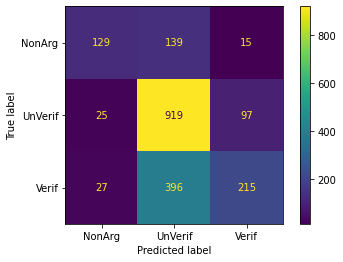

In [15]:
# Call the evaluation
evaluate(y_test, y_pred, classifier, ['NonArg', 'UnVerif', 'Verif'])

***** Evaluation *****
  Accuracy: 0.9341692789968652
 |-----------|-----------|-----------|-----------|
 |Class      |Precision  |Recall     |F1-measure |
 |-----------|-----------|-----------|-----------|
 |NonPers    |0.950664   |0.969052   |0.959770   |
 |Pers       |0.855856   |0.785124   |0.818966   |
 |-----------|-----------|-----------|-----------|
 |MACRO-AVG  |0.903260   |0.877088   |0.889368   |
 |-----------|-----------|-----------|-----------|


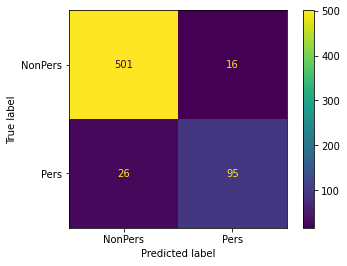

In [ ]:
# Evaluate for verifiable personal/nonpersonal
evaluate(y_test_verif_pers, y_pred_verif_pers, classifier, ['NonPers', 'Pers'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


***** Evaluation *****
  Accuracy: 0.7856603773584906
 |-----------|-----------|-----------|-----------|
 |Class      |Precision  |Recall     |F1-measure |
 |-----------|-----------|-----------|-----------|
 |UnVerif    |0.785660   |1.000000   |0.879966   |
 |VerifEasy  |nan        |0.000000   |nan        |
 |-----------|-----------|-----------|-----------|
 |MACRO-AVG  |nan        |0.500000   |nan        |
 |-----------|-----------|-----------|-----------|


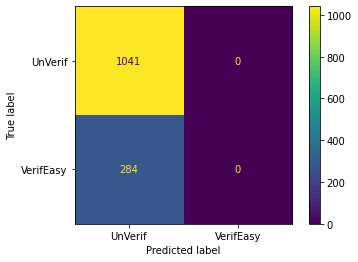

In [ ]:
evaluate(y_test_easy_unverif, y_pred_dummy_easy_unverif, dummy_clf, ['UnVerif', 'VerifEasy'])

***** Evaluation *****
  Accuracy: 0.7462365591397849
 |-----------|-----------|-----------|-----------|
 |Class      |Precision  |Recall     |F1-measure |
 |-----------|-----------|-----------|-----------|
 |UnVerif    |0.746237   |1.000000   |0.854680   |
 |VerifDifficult|nan        |0.000000   |nan        |
 |-----------|-----------|-----------|-----------|
 |MACRO-AVG  |nan        |0.500000   |nan        |
 |-----------|-----------|-----------|-----------|


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


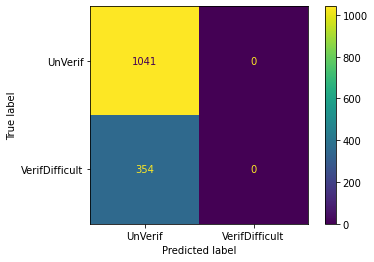

In [ ]:
evaluate(y_test_difficult_unverif, y_pred_dummy_difficult_unverif, dummy_clf, ['UnVerif', 'VerifDifficult'])

***** Evaluation *****
  Accuracy: 0.5902140672782875
 |-----------|-----------|-----------|-----------|
 |Class      |Precision  |Recall     |F1-measure |
 |-----------|-----------|-----------|-----------|
 |UnVerif    |0.775758   |0.452297   |0.571429   |
 |VerifEasy  |0.722590   |0.943324   |0.818333   |
 |NonArg     |0.571429   |0.169014   |0.260870   |
 |-----------|-----------|-----------|-----------|
 |MACRO-AVG  |0.689925   |0.521545   |0.550210   |
 |-----------|-----------|-----------|-----------|


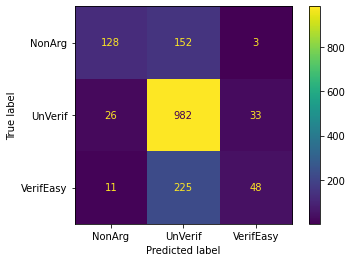

In [ ]:
# VerifEasy/UnVerif, but with original test set
evaluate(y_test_all_except_verifdifficult, y_pred_all_except_verifdifficult, classifier, ['UnVerif', 'VerifEasy', 'NonArg'])

***** Evaluation *****
  Accuracy: 0.5902140672782875
 |-----------|-----------|-----------|-----------|
 |Class      |Precision  |Recall     |F1-measure |
 |-----------|-----------|-----------|-----------|
 |UnVerif    |0.757396   |0.452297   |0.566372   |
 |VerifDifficult|0.694744   |0.926993   |0.794239   |
 |NonArg     |0.541667   |0.183616   |0.274262   |
 |-----------|-----------|-----------|-----------|
 |MACRO-AVG  |0.664603   |0.520969   |0.544957   |
 |-----------|-----------|-----------|-----------|


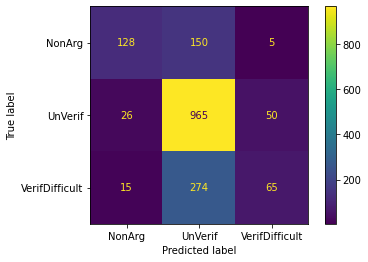

In [ ]:
# VerifDifficult/UnVerif, but with original test set
evaluate(y_test_all_except_verifeasy, y_pred_all_except_verifeasy, classifier, ['UnVerif', 'VerifDifficult', 'NonArg'])

[0.2256848  0.         0.         ... 0.00538587 0.00153882 0.00153882]
['000', '00pm', '00pm flight', '1', '10', '10 years', '100', '1000', '11', '12', '15', '16', '18', '2', '20', '2016', '25', '3', '30', '4', '40', '5', '50', '509', '6', '60', '7', '8', '80', '9', '90', 'a', 'a baby', 'a bad', 'a bastion', 'a bathroom', 'a better', 'a big', 'a biological', 'a bit', 'a black', 'a bunch', 'a burden', 'a case', 'a certain', 'a chance', 'a child', 'a choice', 'a company', 'a computer', 'a conservative', 'a contract', 'a country', 'a couple', 'a crime', 'a cultural', 'a decent', 'a decision', 'a degree', 'a deterrent', 'a difference', 'a different', 'a double', 'a drain', 'a drunk', 'a fact', 'a fair', 'a fetus', 'a few', 'a field', 'a flight', 'a form', 'a full', 'a gay', 'a general', 'a girl', 'a good', 'a government', 'a great', 'a group', 'a gun', 'a guy', 'a higher', 'a huge', 'a human', 'a job', 'a kid', 'a korean', 'a large', 'a larger', 'a law', 'a liberal', 'a life', 'a little',

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, 'Feature Name')

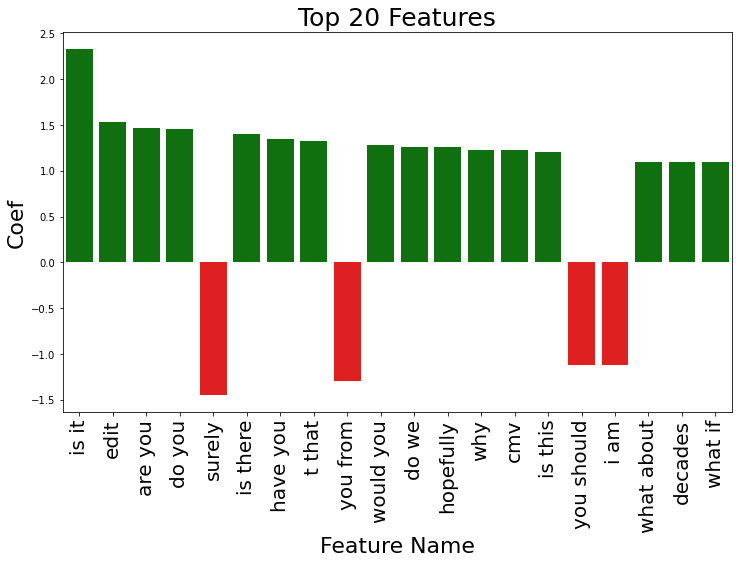

In [ ]:
# VISUALIZE MOST IMPORTANT FEATURES FOR NONARG
# Get the coefficients of each feature
coefs = classifier.named_steps["clf"].coef_

nonarg_coefs = coefs[0].toarray()[0]
print(nonarg_coefs)

# Get feature names
unigram_bigram = (classifier
              .named_steps["features"]
              .transformer_list[0][1]
              .named_steps["bigram"]
              .get_feature_names())

POS_tag = (classifier
              .named_steps["features"]
              .transformer_list[1][1]
              .named_steps["POS-tag"]
              .get_feature_names())


POV = (classifier
              .named_steps["features"]
              .transformer_list[2][1]
              .named_steps["POV-tag"]
              .get_feature_names())

tense = (classifier
              .named_steps["features"]
              .transformer_list[3][1]
              .named_steps["tense"]
              .get_feature_names())

# word_count = (classifier
#               .named_steps["features"]
#               .transformer_list[4][1]
#               .named_steps["wordCount"]
#               .get_feature_names())

tfidf = (classifier
           .named_steps["features"]
           .transformer_list[5][1]
           .named_steps["tfidf"]
           .get_feature_names())

feature_names = unigram_bigram + POS_tag + POV + tense + tfidf

# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, nonarg_coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"]) # Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df.head()
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)


# Make the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

[ 0.46966844 -0.01292404  0.         ...  0.00723797  0.00206799
  0.00206799]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, 'Feature Name')

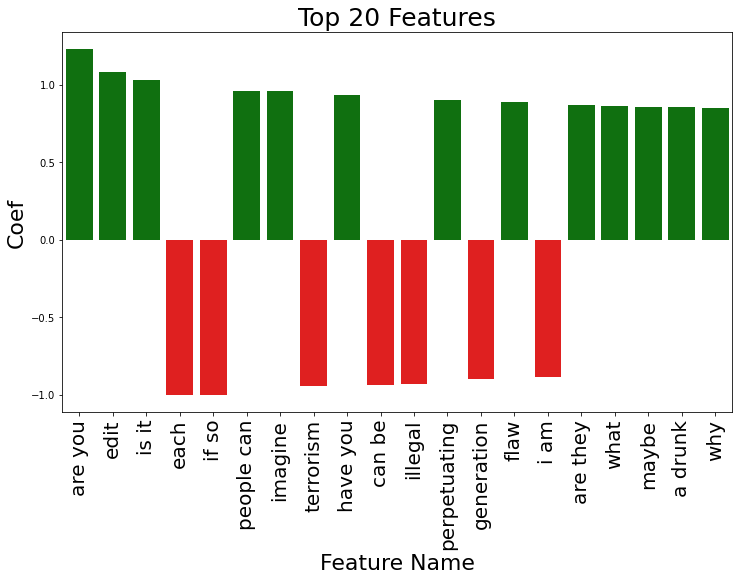

In [ ]:
# VISUALIZE MOST IMPORTANT FEATURES FOR UNVERIF

unverif_coefs = coefs[1].toarray()[0]
print(unverif_coefs)

# Get feature names
unigram_bigram = (classifier
              .named_steps["features"]
              .transformer_list[0][1]
              .named_steps["bigram"]
              .get_feature_names())

POS_tag = (classifier
              .named_steps["features"]
              .transformer_list[1][1]
              .named_steps["POS-tag"]
              .get_feature_names())


POV = (classifier
              .named_steps["features"]
              .transformer_list[2][1]
              .named_steps["POV-tag"]
              .get_feature_names())

tense = (classifier
              .named_steps["features"]
              .transformer_list[3][1]
              .named_steps["tense"]
              .get_feature_names())

# word_count = (classifier
#               .named_steps["features"]
#               .transformer_list[4][1]
#               .named_steps["wordCount"]
#               .get_feature_names())

tfidf = (classifier
           .named_steps["features"]
           .transformer_list[5][1]
           .named_steps["tfidf"]
           .get_feature_names())

feature_names = unigram_bigram + POS_tag + POV + tense + tfidf

# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, unverif_coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"]) # Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df.head()
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)


# Make the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

[-0.10473144  0.60121419  0.13645228 ...  0.          0.
  0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, 'Feature Name')

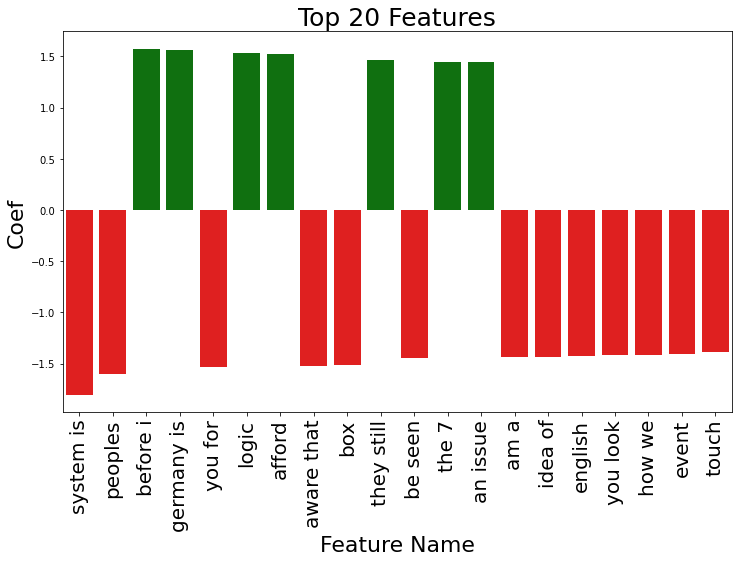

In [ ]:
# VISUALIZE MOST IMPORTANT FEATURES FOR Verif


verif_coefs = coefs[2].toarray()[0]
print(verif_coefs)

# Get feature names
unigram_bigram = (classifier
              .named_steps["features"]
              .transformer_list[0][1]
              .named_steps["bigram"]
              .get_feature_names())

POS_tag = (classifier
              .named_steps["features"]
              .transformer_list[1][1]
              .named_steps["POS-tag"]
              .get_feature_names())


POV = (classifier
              .named_steps["features"]
              .transformer_list[2][1]
              .named_steps["POV-tag"]
              .get_feature_names())

tense = (classifier
              .named_steps["features"]
              .transformer_list[3][1]
              .named_steps["tense"]
              .get_feature_names())

# word_count = (classifier
#               .named_steps["features"]
#               .transformer_list[4][1]
#               .named_steps["wordCount"]
#               .get_feature_names())

tfidf = (classifier
           .named_steps["features"]
           .transformer_list[5][1]
           .named_steps["tfidf"]
           .get_feature_names())

feature_names = unigram_bigram + POS_tag + POV + tense + tfidf

# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, verif_coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"]) # Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df.head()
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)


# Make the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)